# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#format for floats
pd.options.display.float_format = '{:,.8f}'.format

#install necessary libraries
!pip install pyxlsb
!pip install statsmodels

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 6)
import seaborn as sns

### Load Datasets

In [2]:
df0 = pd.read_csv('../Neueda2023/Datasets/2010.csv')
df1 = pd.read_csv('../Neueda2023/Datasets/2011.csv')
df2 = pd.read_csv('../Neueda2023/Datasets/2012.csv')
df3 = pd.read_csv('../Neueda2023/Datasets/2013.csv')
df4 = pd.read_csv('../Neueda2023/Datasets/2014.csv')
df5 = pd.read_csv('../Neueda2023/Datasets/2015.csv')
df6 = pd.read_csv('../Neueda2023/Datasets/2016.csv')

In [3]:
df_combined = pd.concat([df0, df1, df2, df3, df4, df5, df6])
df_combined.head(3)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2010,274,188,80,6,0,0,0,150,71,43,0,0,192,82,0
1,Alabama,Clay,2010,113,79,34,0,0,0,0,86,60,42,0,0,0,113,0
2,Alabama,Colbert,2010,355,208,146,1,0,0,0,105,67,47,0,0,114,241,0


### Clean Vehicle Data

In [4]:
df_ev = pd.read_excel("./Datasets/vehicle.xlsb", sheet_name="County", engine="pyxlsb", header=1)
df_ev.head(3)

,state_abbr,geoid,county_id,county_name,fuel_type_org,fuel_type,class,before 1980,1980-99,1990-99,...,2009.1,2010.1,2011.1,2012.1,2013.1,2014.1,2015.1,2016.1,2017.1,2018.1
0,AL,1001,1001,Autauga,BI,Other/Unknown,Car,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,1001,1001,Autauga,BI,Other/Unknown,Truck,NaN,NaN,0.00001904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,1001,1001,Autauga,DIES,Diesel vehicle,Car,NaN,0.00019045,0.00003809,...,0.00000571,0.00000000,0.00000950,0.00000728,0.00000867,0.00001158,0.00000502,NaN,NaN,NaN


In [5]:
#Select Years of Interest (Percentage of Vehicle Sales by Jurisdiction)
df_ev = df_ev.iloc[:, [0, 3, 4, 20, 21, 22, 23, 24, 25, 26]]

In [6]:
# Fill NAs with 0s
df_ev = df_ev.fillna(0)
df_ev

,state_abbr,county_name,fuel_type_org,2010,2011,2012,2013,2014,2015,2016
0,AL,Autauga,BI,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,AL,Autauga,BI,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,AL,Autauga,DIES,0.00015236,0.00022854,0.00020949,0.00026663,0.00036185,0.00017140,0.00000000
3,AL,Autauga,DIES,0.00038089,0.00108555,0.00097128,0.00068561,0.00064752,0.00173307,0.00163785
4,AL,Autauga,DIES,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...
50810,WY,Weston,GAS,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
50811,WY,Weston,HYBRID ELECTRIC VEHICLE,0.00046959,0.00035220,0.00011740,0.00070439,0.00035220,0.00011740,0.00023480
50812,WY,Weston,HYBRID ELECTRIC VEHICLE,0.00000000,0.00011740,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
50813,WY,Weston,PLUG IN HYBRID ELECTRIC VEHICLE,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [7]:
#Normalize the Data - Pivot Longer
df_total = pd.melt(df_ev, id_vars=['state_abbr', 'county_name'], value_vars=[2010, 2011, 2012, 2013, 2014, 2015, 2016], var_name="Year", value_name="Total Average Percentage of Vehicle Sales")

#Group by Year, State, and County and Convert to a Percentage
df_total = df_total.groupby(['Year', 'state_abbr', 'county_name']).sum()*100
df_total

Total Average Percentage of Vehicle Sales
Year state_abbr county_name                                              
2010 AK         Aleutians East                                 4.41176471
                Aleutians West                                 2.64353573
                Anchorage                                      4.01673854
                Bethel                                         3.26487625
                Bristol Bay                                    2.07808564
...                                                                   ...
2016 WY         Sweetwater                                     3.22813531
                Teton                                          4.30333246
                Uinta                                          2.70188352
                Washakie                                       2.51645785
                Weston                                         2.48884715

[21952 rows x 1 columns]

In [8]:
# Aggregrate County Level Data
df_total = df_total.groupby(['Year', 'state_abbr']).mean()
df_total

Total Average Percentage of Vehicle Sales
Year state_abbr                                           
2010 AK                                         2.90304416
     AL                                         3.16879169
     AR                                         3.48272388
     AZ                                         2.57246991
     CA                                         3.14388840
...                                                    ...
2016 VT                                         6.55573259
     WA                                         2.72437922
     WI                                         3.84591951
     WV                                         4.14069607
     WY                                         2.80074467

[357 rows x 1 columns]

In [9]:
### Repeat Process, but Only for Electric Vehicles
df_ev2 = df_ev.loc[df_ev['fuel_type_org'].isin(['ELECTRIC VEHICLE', 'HYBRID ELECTRIC VEHICLE', 'PLUG IN HYBRID ELECTRIC VEHICLE'])]
df_ev2

,state_abbr,county_name,fuel_type_org,2010,2011,2012,2013,2014,2015,2016
5,AL,Autauga,ELECTRIC VEHICLE,0.00000000,0.00000000,0.00000000,0.00000000,0.00003809,0.00001904,0.00003809
12,AL,Autauga,HYBRID ELECTRIC VEHICLE,0.00055230,0.00039994,0.00057134,0.00085701,0.00049516,0.00049516,0.00024758
13,AL,Autauga,HYBRID ELECTRIC VEHICLE,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
14,AL,Autauga,PLUG IN HYBRID ELECTRIC VEHICLE,0.00000000,0.00000000,0.00003809,0.00000000,0.00000000,0.00001904,0.00000000
24,AL,Baldwin,ELECTRIC VEHICLE,0.00001932,0.00002898,0.00002898,0.00002898,0.00004831,0.00005314,0.00002898
...,...,...,...,...,...,...,...,...,...,...
50797,WY,Washakie,PLUG IN HYBRID ELECTRIC VEHICLE,0.00000000,0.00000000,0.00010618,0.00000000,0.00000000,0.00000000,0.00000000
50804,WY,Weston,ELECTRIC VEHICLE,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
50811,WY,Weston,HYBRID ELECTRIC VEHICLE,0.00046959,0.00035220,0.00011740,0.00070439,0.00035220,0.00011740,0.00023480
50812,WY,Weston,HYBRID ELECTRIC VEHICLE,0.00000000,0.00011740,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [10]:
df_ev2 = pd.melt(df_ev2, id_vars=['county_name', 'state_abbr'], value_vars=[2010, 2011, 2012, 2013, 2014, 2015, 2016], var_name="Year", value_name="Total Average Percentage of EV Sales")
df_ev2

,county_name,state_abbr,Year,Total Average Percentage of EV Sales
0,Autauga,AL,2010,0.00000000
1,Autauga,AL,2010,0.00055230
2,Autauga,AL,2010,0.00000000
3,Autauga,AL,2010,0.00000000
4,Baldwin,AL,2010,0.00001932
...,...,...,...,...
85325,Washakie,WY,2016,0.00000000
85326,Weston,WY,2016,0.00000000
85327,Weston,WY,2016,0.00023480
85328,Weston,WY,2016,0.00000000


In [11]:
df_ev2 = df_ev2.groupby(["Year", "state_abbr", 'county_name']).sum() * 100
df_ev2

Total Average Percentage of EV Sales
Year state_abbr county_name                                         
2010 AK         Aleutians East                            0.00000000
                Aleutians West                            0.04130525
                Anchorage                                 0.10416060
                Bethel                                    0.02632965
                Bristol Bay                               0.00000000
...                                                              ...
2016 WY         Sweetwater                                0.02268977
                Teton                                     0.15369044
                Uinta                                     0.00865988
                Washakie                                  0.02123593
                Weston                                    0.02347969

[21952 rows x 1 columns]

In [12]:
df_ev2 = df_ev2.groupby(["Year", "state_abbr"]).mean()
df_ev2

Total Average Percentage of EV Sales
Year state_abbr                                      
2010 AK                                    0.04511183
     AL                                    0.03718625
     AR                                    0.04918869
     AZ                                    0.08373759
     CA                                    0.21740108
...                                               ...
2016 VT                                    0.18624077
     WA                                    0.11326952
     WI                                    0.06137709
     WV                                    0.03440535
     WY                                    0.03332716

[357 rows x 1 columns]

### Clean Air Quality Dataset

In [13]:
#Load in State Mapping to Merge the 2 datasets
state_codes = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

In [14]:
df_combined.head(3)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2010,274,188,80,6,0,0,0,150,71,43,0,0,192,82,0
1,Alabama,Clay,2010,113,79,34,0,0,0,0,86,60,42,0,0,0,113,0
2,Alabama,Colbert,2010,355,208,146,1,0,0,0,105,67,47,0,0,114,241,0


In [15]:
df_combined["State"] = df_combined["State"].map(state_codes)

In [16]:
df_combined.head(3)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,AL,Baldwin,2010,274,188,80,6,0,0,0,150,71,43,0,0,192,82,0
1,AL,Clay,2010,113,79,34,0,0,0,0,86,60,42,0,0,0,113,0
2,AL,Colbert,2010,355,208,146,1,0,0,0,105,67,47,0,0,114,241,0


In [17]:
#Group By Year and State
df_combined = df_combined.drop("County", axis="columns")

In [18]:
df_combined = df_combined.groupby(['Year', 'State']).mean()

In [19]:
df_combined

Days with AQI    Good Days  Moderate Days   
Year State                                              
2010 AK      262.12500000 222.00000000    35.00000000  \
     AL      282.26315789 164.89473684   113.05263158   
     AR      208.23529412 138.52941176    67.35294118   
     AZ      309.53846154 199.07692308   102.23076923   
     CA      350.39622642 221.94339623   102.33962264   
...                   ...          ...            ...   
2016 VT      301.50000000 279.75000000    21.50000000   
     WA      348.75862069 317.44827586    30.34482759   
     WI      282.92592593 243.25925926    35.85185185   
     WV      272.57142857 237.78571429    34.07142857   
     WY      329.38888889 286.22222222    42.94444444   

            Unhealthy for Sensitive Groups Days  Unhealthy Days   
Year State                                                        
2010 AK                              4.12500000      1.00000000  \
     AL                              4.00000000      0.31578947   
     AR                              2.23529412      0.11764706   
     AZ                              7.92307692      0.15384615   
     CA                             19.88679245      5.32075472   
...                                         ...             ...   
2016 VT                              0.25000000      0.00000000   
     WA                              0.79310345      0.17241379   
     WI                              3.55555556      0.25925926   
     WV                              0.71428571      0.00000000   
     WY                              0.16666667      0.05555556   

            Very Unhealthy Days  Hazardous Days      Max AQI   
Year State                                                     
2010 AK              0.00000000      0.00000000  88.50000000  \
     AL              0.00000000      0.00000000 112.26315789   
     AR              0.00000000      0.00000000 100.00000000   
     AZ              0.00000000      0.15384615 233.46153846   
     CA              0.47169811      0.43396226 305.60377358   
...                         ...             ...          ...   
2016 VT              0.00000000      0.00000000  83.00000000   
     WA              0.00000000      0.00000000  88.17241379   
     WI              0.00000000      0.00000000 118.59259259   
     WV              0.00000000      0.00000000  95.85714286   
     WY              0.00000000      0.00000000  94.77777778   

            90th Percentile AQI  Median AQI    Days CO   Days NO2   
Year State                                                          
2010 AK             44.87500000 19.75000000 2.37500000 0.00000000  \
     AL             70.31578947 46.15789474 0.05263158 0.00000000   
     AR             63.94117647 43.70588235 0.00000000 2.94117647   
     AZ             70.38461538 42.92307692 0.00000000 5.61538462   
     CA             80.60377358 45.30188679 0.15094340 8.90566038   
...                         ...         ...        ...        ...   
2016 VT             42.75000000 29.00000000 0.00000000 3.00000000   
     WA             44.24137931 24.10344828 0.03448276 4.03448276   
     WI             57.55555556 35.96296296 0.00000000 1.33333333   
     WV             52.57142857 35.42857143 4.92857143 0.00000000   
     WY             51.05555556 37.27777778 0.00000000 1.77777778   

             Days Ozone   Days PM2.5   Days PM10  
Year State                                        
2010 AK     59.37500000 191.00000000  9.37500000  
     AL    131.05263158 142.26315789  8.89473684  
     AR    110.35294118  94.94117647  0.00000000  
     AZ    191.23076923  22.76923077 89.92307692  
     CA    222.54716981 105.94339623 12.84905660  
...                 ...          ...         ...  
2016 VT    217.00000000  81.50000000  0.00000000  
     WA     53.34482759 287.44827586  3.89655172  
     WI    195.40740741  85.88888889  0.29629630  
     WV    160.50000000  83.21428571 23.92857143  
     WY    267.05555556  16.05555556 44.50000000  

[35

### Merge the Dataset

In [20]:
result = pd.concat([df_combined, df_ev2, df_total], axis=1, join="inner")
result.head(3)

Days with AQI    Good Days  Moderate Days   
Year                                                 
2010 AK   262.12500000 222.00000000    35.00000000  \
     AL   282.26315789 164.89473684   113.05263158   
     AR   208.23529412 138.52941176    67.35294118   

         Unhealthy for Sensitive Groups Days  Unhealthy Days   
Year                                                           
2010 AK                           4.12500000      1.00000000  \
     AL                           4.00000000      0.31578947   
     AR                           2.23529412      0.11764706   

         Very Unhealthy Days  Hazardous Days      Max AQI   
Year                                                        
2010 AK           0.00000000      0.00000000  88.50000000  \
     AL           0.00000000      0.00000000 112.26315789   
     AR           0.00000000      0.00000000 100.00000000   

         90th Percentile AQI  Median AQI    Days CO   Days NO2   Days Ozone   
Year                                                                          
2010 AK          44.87500000 19.75000000 2.37500000 0.00000000  59.37500000  \
     AL          70.31578947 46.15789474 0.05263158 0.00000000 131.05263158   
     AR          63.94117647 43.70588235 0.00000000 2.94117647 110.35294118   

          Days PM2.5  Days PM10  Total Average Percentage of EV Sales   
Year                                                                    
2010 AK 191.00000000 9.37500000                            0.04511183  \
     AL 142.26315789 8.89473684                            0.03718625   
     AR  94.94117647 0.00000000                            0.04918869   

         Total Average Percentage of Vehicle Sales  
Year                                                
2010 AK                                 2.90304416  
     AL                                 3.16879169  
     AR                                 3.48272388

In [21]:
#Calculate Total Vehicle Sale
result['Total Average Percentage of Non-EV Vehicle Sales'] = result['Total Average Percentage of Vehicle Sales'] - result['Total Average Percentage of EV Sales']
result.head(3)

Days with AQI    Good Days  Moderate Days   
Year                                                 
2010 AK   262.12500000 222.00000000    35.00000000  \
     AL   282.26315789 164.89473684   113.05263158   
     AR   208.23529412 138.52941176    67.35294118   

         Unhealthy for Sensitive Groups Days  Unhealthy Days   
Year                                                           
2010 AK                           4.12500000      1.00000000  \
     AL                           4.00000000      0.31578947   
     AR                           2.23529412      0.11764706   

         Very Unhealthy Days  Hazardous Days      Max AQI   
Year                                                        
2010 AK           0.00000000      0.00000000  88.50000000  \
     AL           0.00000000      0.00000000 112.26315789   
     AR           0.00000000      0.00000000 100.00000000   

         90th Percentile AQI  Median AQI    Days CO   Days NO2   Days Ozone   
Year                                                                          
2010 AK          44.87500000 19.75000000 2.37500000 0.00000000  59.37500000  \
     AL          70.31578947 46.15789474 0.05263158 0.00000000 131.05263158   
     AR          63.94117647 43.70588235 0.00000000 2.94117647 110.35294118   

          Days PM2.5  Days PM10  Total Average Percentage of EV Sales   
Year                                                                    
2010 AK 191.00000000 9.37500000                            0.04511183  \
     AL 142.26315789 8.89473684                            0.03718625   
     AR  94.94117647 0.00000000                            0.04918869   

         Total Average Percentage of Vehicle Sales   
Year                                                 
2010 AK                                 2.90304416  \
     AL                                 3.16879169   
     AR                                 3.48272388   

         Total Average Percentage of Non-EV Vehicle Sales  
Year                                                       
2010 AK                                        2.85793234  
     AL                                        3.13160544  
     AR                                        3.43353519

### Export to CSV

In [22]:
result.to_csv("analysis.csv", sep='\t', encoding='utf-8')

# Multiple Linear Regression

### Initial Exploratory Data Analysis

In [24]:
result.describe()

,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total Average Percentage of EV Sales,Total Average Percentage of Vehicle Sales,Total Average Percentage of Non-EV Vehicle Sales
count,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000
mean,306.73967369,237.39761834,64.51019969,4.13514965,0.61698172,0.04555904,0.03416525,121.68759207,59.98941387,37.04152447,0.63026409,6.00379734,170.86482134,113.29354976,15.94724115,0.08713821,4.40513220,4.31799399
std,37.62677564,40.45798057,24.63448740,4.64822107,1.15376179,0.15384641,0.14749882,39.37222836,10.08075279,5.78326991,2.80304073,8.01568480,60.75221913,62.01888371,24.23009357,0.05616925,1.07865289,1.05411596
min,201.36363636,136.78947368,11.70000000,0.00000000,0.00000000,0.00000000,0.00000000,72.00000000,42.00000000,19.75000000,0.00000000,0.00000000,28.00000000,12.50000000,0.00000000,0.01253616,2.23947893,2.21165503
25%,281.72654462,207.95275120,45.47368421,1.01086957,0.02580972,0.00000000,0.00000000,98.80833333,52.51785714,33.89166667,0.00000000,1.25000000,137.48809524,74.83031401,0.31168831,0.04500151,3.65377360,3.58028025
50%,306.44720497,235.66842105,59.79347826,2.70142602,0.16172624,0.00000000,0.00000000,111.97368421,57.89772727,37.82046332,0.03125000,3.29659091,184.14144737,101.05305040,4.04166667,0.07082284,4.23872020,4.17020424
75%,339.84767442,265.68571429,80.30937500,5.32812500,0.57720588,0.00000000,0.00000000,130.61029412,65.30357143,40.72554348,0.22222222,6.60000000,212.81818182,133.83573718,21.80434783,0.11744155,5.03810383,4.94960547
max,365.33333333,350.80000000,130.66666667,25.85185185,7.01851852,1.60000000,1.40000000,471.03703704,91.33333333,49.42592593,33.90000000,43.21052632,306.85714286,326.33333333,130.61538462,0.36733459,7.74749914,7.62133788


array([[<Axes: title={'center': 'Max AQI'}>,
        <Axes: title={'center': 'Total Average Percentage of EV Sales'}>],
       [<Axes: title={'center': 'Total Average Percentage of Non-EV Vehicle Sales'}>,
        <Axes: >]], dtype=object)

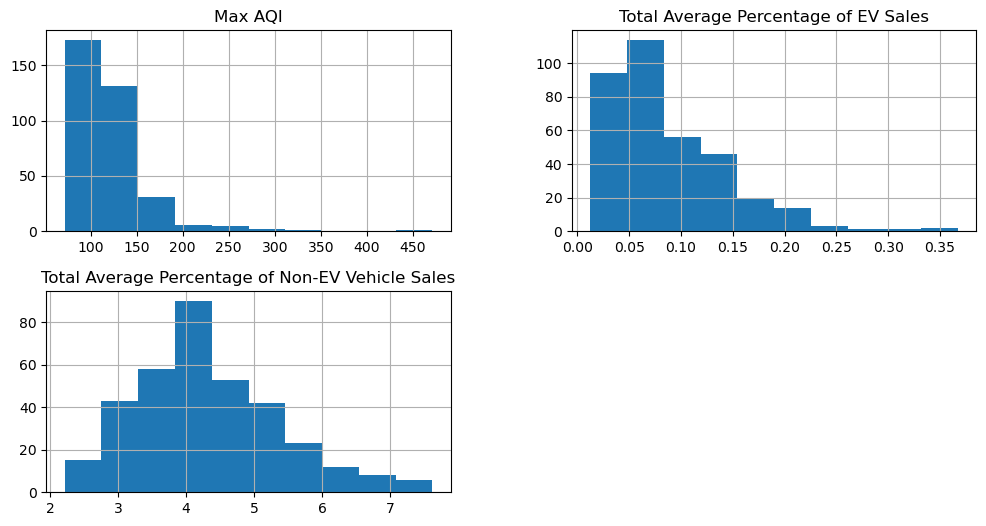

In [25]:
result[['Max AQI', 'Total Average Percentage of EV Sales', 'Total Average Percentage of Non-EV Vehicle Sales']].hist()

In [26]:
#Transform Data
result_log = result
# result['Unhealthy for Sensitive Groups Days'] = np.log(result['Unhealthy for Sensitive Groups Days'] + 1)
# result['Unhealthy Days'] = np.log(result['Unhealthy Days'] + 1)
# result['Very Unhealthy Days'] = np.log(result['Very Unhealthy Days'] + 1)
# result['Hazardous Days'] = np.log(result['Hazardous Days'] + 1)
result_log['Max AQI'] = np.log(result['Max AQI'])
# result['Days CO'] = np.log(result['Days CO'] + 1)
# result['Days NO2'] = np.log(result['Days NO2']  + 1)
# result['Days PM10'] = np.log(result['Days PM10'] + 1)
result_log['Total Average Percentage of EV Sales'] = np.log(result['Total Average Percentage of EV Sales'] + .0001)
result_log['Total Average Percentage of Non-EV Vehicle Sales'] = np.log(result['Total Average Percentage of Non-EV Vehicle Sales'] + .0001)

In [27]:
result_log.describe()

,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total Average Percentage of EV Sales,Total Average Percentage of Vehicle Sales,Total Average Percentage of Non-EV Vehicle Sales
count,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000,350.00000000
mean,306.73967369,237.39761834,64.51019969,4.13514965,0.61698172,0.04555904,0.03416525,4.76478259,59.98941387,37.04152447,0.63026409,6.00379734,170.86482134,113.29354976,15.94724115,-2.62766852,4.40513220,1.43360950
std,37.62677564,40.45798057,24.63448740,4.64822107,1.15376179,0.15384641,0.14749882,0.25378802,10.08075279,5.78326991,2.80304073,8.01568480,60.75221913,62.01888371,24.23009357,0.62014011,1.07865289,0.24251104
min,201.36363636,136.78947368,11.70000000,0.00000000,0.00000000,0.00000000,0.00000000,4.27666612,42.00000000,19.75000000,0.00000000,0.00000000,28.00000000,12.50000000,0.00000000,-4.37119245,2.23947893,0.79378633
25%,281.72654462,207.95275120,45.47368421,1.01086957,0.02580972,0.00000000,0.00000000,4.59318194,52.51785714,33.89166667,0.00000000,1.25000000,137.48809524,74.83031401,0.31168831,-3.09884046,3.65377360,1.27546899
50%,306.44720497,235.66842105,59.79347826,2.70142602,0.16172624,0.00000000,0.00000000,4.71826385,57.89772727,37.82046332,0.03125000,3.29659091,184.14144737,101.05305040,4.04166667,-2.64622611,4.23872020,1.42798888
75%,339.84767442,265.68571429,80.30937500,5.32812500,0.57720588,0.00000000,0.00000000,4.87221765,65.30357143,40.72554348,0.22222222,6.60000000,212.81818182,133.83573718,21.80434783,-2.14096365,5.03810383,1.59932673
max,365.33333333,350.80000000,130.66666667,25.85185185,7.01851852,1.60000000,1.40000000,6.15493673,91.33333333,49.42592593,33.90000000,43.21052632,306.85714286,326.33333333,130.61538462,-1.00120996,7.74749914,2.03096505


array([[<Axes: title={'center': 'Max AQI'}>,
        <Axes: title={'center': 'Total Average Percentage of EV Sales'}>],
       [<Axes: title={'center': 'Total Average Percentage of Non-EV Vehicle Sales'}>,
        <Axes: >]], dtype=object)

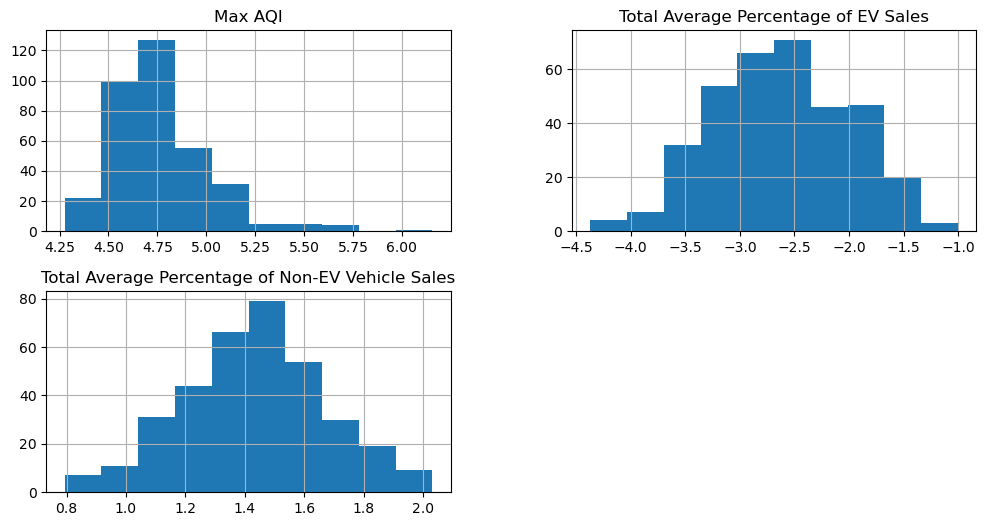

In [28]:
result[['Max AQI', 'Total Average Percentage of EV Sales', 'Total Average Percentage of Non-EV Vehicle Sales']].hist()

We transformed some of the variables to normalize the distribution.

### Fit Model

In [29]:
y = result_log['Max AQI']
X = result_log[['Total Average Percentage of EV Sales', 'Total Average Percentage of Non-EV Vehicle Sales']]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

### Model Diagnostics

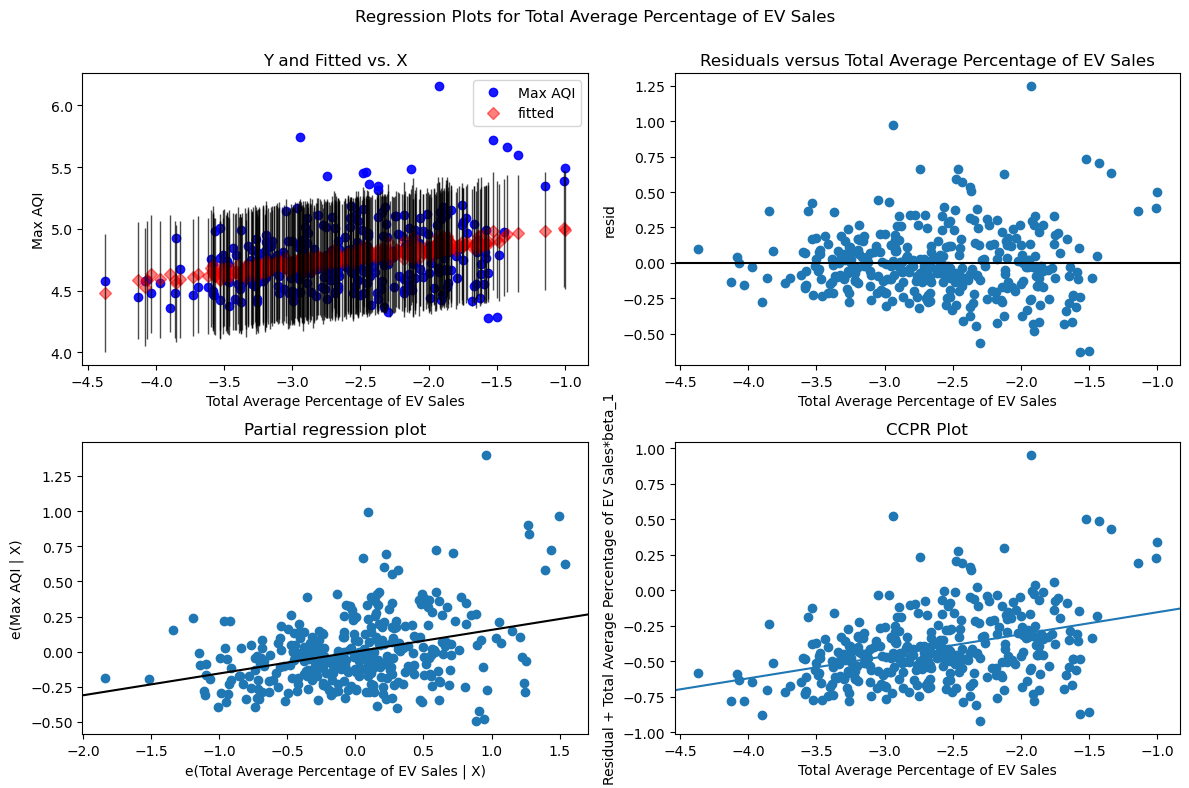

In [30]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(est2,'Total Average Percentage of EV Sales', fig=fig)

Residuals seem randomly scattered with no major issues, so we proceed with analysis on the model.

### Analysis

In [31]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Max AQI   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     23.26
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           3.32e-10
Time:                        18:40:06   Log-Likelihood:                 5.8277
No. Observations:                 350   AIC:                            -5.655
Df Residuals:                     347   BIC:                             5.918
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------